In [ ]:
import os
from datetime import datetime
import pandas as pd
import geopandas as gpd

from eo_flood_ops.thresholding_model import ThresholdingModel 
from eo_flood_ops.general_utils import *  # noqa: F403
from eo_flood_ops.model_utils import GroundTruthMeasurement, LaplaceDepthSolverConfig
from eo_flood_ops.manifold_model import ManifoldModel

class MyGroundTruthMeasurement(GroundTruthMeasurement):
  pass

In [3]:
images_dir = R"p:\11211461-010--eo-flood-ops\HoiAn\classified_events"
aoi_dir = R"p:\11211461-010--eo-flood-ops\HoiAn\AOI"
waterlevels_fn = R"p:\11211461-010--eo-flood-ops\HoiAn\water_levels\Water_Level.csv"
dem_fn = R"p:\11211461-010--eo-flood-ops\HoiAn\DEMs\hoi_an_FABDEM.tif"

In [4]:
df_water = pd.read_csv(waterlevels_fn, skiprows=[1])
df_water.rename(columns={df_water.columns[0]: "datetime"}, inplace=True)
df_water["datetime"] = pd.to_datetime(df_water["datetime"])


In [5]:
results_per_aoi = {}

# Loop over AOI files
for aoi_file in os.listdir(aoi_dir):
    if not aoi_file.endswith('.geojson'):
        continue
    
    aoi_name = aoi_file.split('_')[1].split('.')[0]

    print(f"Processing AOI: {aoi_name}")
    print("*" * 45)
    # Store image-water level tuples
    image_water_levels = []
    
    # Loop over images
    for image_name in os.listdir(images_dir):
        if not image_name.endswith(".tif"):
            continue
        

        datetime_str = image_name.split("_")[1].replace(".tif", "") 
        dt = datetime.strptime(datetime_str, "%Y%m%dT%H%M%S")
        dt = pd.Timestamp(dt)
        dt_gmt7 = dt + pd.Timedelta(hours=7)  # Convert to GMT+7

        closest_time, value = find_closest_valid(df_water, dt_gmt7, aoi_name)

        if closest_time is not None:
            print(f"Image: {image_name}")
            print(f"Image timestamp (GMT+7): {dt_gmt7}")
            print("Closest valid timestamp:", closest_time)
            print(f"{aoi_name} value:", value)
            print("=" * 45)
            image_water_levels.append((image_name, value))
        else:
            print(f"No valid {aoi_name} values found in dataset for image {image_name}.")

    if not image_water_levels:
        print(f"No images found for AOI: {aoi_name}")
        continue

    # print some spacing to improve readability
    print("\n" * 1)

    # Sort by water level ascending
    image_water_levels.sort(key=lambda x: x[1])
    
    # Store results
    results_per_aoi[aoi_name] = image_water_levels

Processing AOI: ID6
*********************************************
Image: hoian_20221015T105600.tif
Image timestamp (GMT+7): 2022-10-15 17:56:00
Closest valid timestamp: 2022-10-15 18:00:00
ID6 value: 3.25
Image: hoian_20221202T105600.tif
Image timestamp (GMT+7): 2022-12-02 17:56:00
Closest valid timestamp: 2022-12-02 18:00:00
ID6 value: 1.29
Image: hoian_20221206T223600.tif
Image timestamp (GMT+7): 2022-12-07 05:36:00
Closest valid timestamp: 2022-12-07 05:40:00
ID6 value: 1.31
Image: hoian_20231115T105600.tif
Image timestamp (GMT+7): 2023-11-15 17:56:00
Closest valid timestamp: 2023-11-15 18:00:00
ID6 value: 2.06




In [6]:
# Prepare GROUND TRUTH for each AOI

# Dictionary to store GROUND_TRUTH per AOI
GROUND_TRUTH_per_aoi = {}

for aoi_file in os.listdir(aoi_dir):
    if not aoi_file.endswith('.geojson'):
        continue
    
    aoi_name = aoi_file.split('_')[1].split('.')[0]
    
    aoi_fn = os.path.join(aoi_dir, aoi_file)
    
    # Make sure we have results for this AOI
    if aoi_name not in results_per_aoi:
        print(f"No images found for AOI: {aoi_name}")
        continue
    
    GROUND_TRUTH = []
    
    for image_name, water_level in results_per_aoi[aoi_name]:
        image_path = os.path.join(images_dir, image_name)
        
        masked_array, transforms, crs = tif_to_clipped_masked_array(
            image_path,
            aoi_fn,
        )
        
        GROUND_TRUTH.append(MyGroundTruthMeasurement(
            ground_truth=masked_array,
            gauge_measurement=water_level
        ))
    
    # Store per AOI
    GROUND_TRUTH_per_aoi[aoi_name] = GROUND_TRUTH

In [7]:
MIN_RATIOS = [0.1, 0.3, 0.5, 1, 2, 5, 10, 15, 20]

trained_models_tm= {}
validation_set = {}

for aoi_name, GROUND_TRUTH in GROUND_TRUTH_per_aoi.items():
    print("\n" + "="*60)
    print(f"Starting training for AOI: {aoi_name}")
    print(f"Using minimum ratios: {MIN_RATIOS}")

    training_ground_truth = GROUND_TRUTH[:-1] # Leave last one out for validation as it is the most extreme one
    print(f"Number of ground truth images: {len(training_ground_truth)}")

    validation_set[aoi_name] = GROUND_TRUTH[-1] # The most extreme one
    
    tm = ThresholdingModel()
    
    tm.train(
        minumum_ratios=MIN_RATIOS,
        ground_truth=training_ground_truth
    )
    
    trained_models_tm[aoi_name] = tm
    print(f"Finished training for AOI: {aoi_name}")
    print("="*60)


Starting training for AOI: ID6
Using minimum ratios: [0.1, 0.3, 0.5, 1, 2, 5, 10, 15, 20]
Number of ground truth images: 3


c:\Users\tsiokano\git\EO-Flood-Ops\.venv\Lib\site-packages\eo_flood_ops\model_utils.py:251: RuntimeWarning: divide by zero encountered in divide
  ratios = true_wets / false_wets
c:\Users\tsiokano\git\EO-Flood-Ops\.venv\Lib\site-packages\eo_flood_ops\model_utils.py:251: RuntimeWarning: invalid value encountered in divide
  ratios = true_wets / false_wets


For min_ratio=0.1 we get f1=0.9614689723830243
For min_ratio=0.3 we get f1=0.9614689723830243
For min_ratio=0.5 we get f1=0.9614689723830243
For min_ratio=1 we get f1=0.9677146741972596
For min_ratio=2 we get f1=0.9662201794703434
For min_ratio=5 we get f1=0.9626103158132042
For min_ratio=10 we get f1=0.9626103158132042
For min_ratio=15 we get f1=0.9626103158132042
For min_ratio=20 we get f1=0.9626103158132042
chosen min_ratio 1
Finished training for AOI: ID6


In [8]:
max_water_level = [results_per_aoi["ID6"][-1][-1]]
timestamp = pd.date_range("2022-10-15", periods=len(max_water_level))

ds_sim_per_aoi_tm = {}  # dict to store datasets

for aoi_name, trained_model in trained_models_tm.items():    

    # Generate the Dataset for this AOI
    ds_sim_tm = generate_timeseries_ds(
        water_levels=max_water_level,
        timestamps=timestamp,
        tm=trained_model,
        transform=transforms,
        crs=crs
    )

    # Store in the dictionary
    ds_sim_per_aoi_tm[aoi_name] = ds_sim_tm

In [9]:
da_obs = masked_array_to_da(GROUND_TRUTH_per_aoi["ID6"][-1].ground_truth, transforms, crs)
da_sim_tm = ds_sim_per_aoi_tm["ID6"]["wet_dry"].sel(time="2022-10-15").squeeze().raster.flipud()

river_mask = gpd.read_file(aoi_fn)
da_mask = da_sim_tm.raster.geometry_mask(river_mask, all_touched=False)

In [10]:
ds_tm_skill, da_tm_cm = skill(da_sim_tm, da_obs, ~da_mask, hmin=0)


In [11]:
DEM_per_aoi = {}

for aoi_file in os.listdir(aoi_dir):
    if not aoi_file.endswith('.geojson'):
        continue
    if aoi_file.split('_')[1].split('.')[0] == "Modrica":  # skip for now
        continue
    
    aoi_name = aoi_file.split('_')[1].split('.')[0]
    aoi_fn = os.path.join(aoi_dir, aoi_file)
    
    # Clip DEM for this AOI
    DEM, dem_transform, dem_crs = tif_to_clipped_array(dem_fn, aoi_fn)
    
    # Store in a dictionary
    DEM_per_aoi[aoi_name] = {
        'DEM': DEM,
        'transform': dem_transform,
        'crs': dem_crs
    }

In [12]:
trained_models_mm = {}

for aoi_name, GROUND_TRUTH in GROUND_TRUTH_per_aoi.items():
    print("\n" + "="*60)
    print(f"Starting training for AOI: {aoi_name}")
    print(f"Using minimum ratios: {MIN_RATIOS}")

    # Get DEM for this AOI
    DEM = DEM_per_aoi[aoi_name]['DEM']

    training_ground_truth = GROUND_TRUTH[:-1] # Leave last one out for validation as it is the most extreme one
    print(f"Number of ground truth images: {len(training_ground_truth)}")

    # Create the model
    mm = ManifoldModel(
        dem=DEM,
        scale=30,
        laplace_config=LaplaceDepthSolverConfig(
            down_scale_factor=32,
            solve_iterations_factor=3.,
            force_coeff=0.9,
            drop_iterations=1,
            drop_coeff=0.00003
        ),
        force_tolerance=1,
        force_local_region_width=5,
        flood_agree_threshold=0.1
    )

    mm.train(
        minumum_ratios=MIN_RATIOS,
        ground_truth=training_ground_truth
    )

    trained_models_mm[aoi_name] = mm
    print(f"Finished training for AOI: {aoi_name}")
    print("="*60)


Starting training for AOI: ID6
Using minimum ratios: [0.1, 0.3, 0.5, 1, 2, 5, 10, 15, 20]
Number of ground truth images: 3
Training an inner thresholding model used for flood-fill.


c:\Users\tsiokano\git\EO-Flood-Ops\.venv\Lib\site-packages\eo_flood_ops\model_utils.py:251: RuntimeWarning: divide by zero encountered in divide
  ratios = true_wets / false_wets
c:\Users\tsiokano\git\EO-Flood-Ops\.venv\Lib\site-packages\eo_flood_ops\model_utils.py:251: RuntimeWarning: invalid value encountered in divide
  ratios = true_wets / false_wets


For min_ratio=0.1 we get f1=0.9614689723830243
For min_ratio=0.3 we get f1=0.9614689723830243
For min_ratio=0.5 we get f1=0.9614689723830243
For min_ratio=1 we get f1=0.9677146741972596
For min_ratio=2 we get f1=0.9662201794703434
For min_ratio=5 we get f1=0.9626103158132042
For min_ratio=10 we get f1=0.9626103158132042
For min_ratio=15 we get f1=0.9626103158132042
For min_ratio=20 we get f1=0.9626103158132042
chosen min_ratio 1
Running flood extent to depth on ground truth examples..
Running flood extent to depth algorithm for image at gauge_level 1.29
Running flood extent to depth algorithm for image at gauge_level 1.31
Running flood extent to depth algorithm for image at gauge_level 2.06
Finished training for AOI: ID6


In [13]:
ds_sim_per_aoi_mm = {}  # dict to store datasets

for aoi_name, trained_model in trained_models_mm.items():    

    # Generate the Dataset for this AOI
    ds_sim_mm = generate_timeseries_ds(
        water_levels=max_water_level,
        timestamps=timestamp,
        tm=trained_model,
        transform=transforms,
        crs=crs
    )

    # Store in the dictionary
    ds_sim_per_aoi_mm[aoi_name] = ds_sim_mm

In [14]:
da_sim_mm = ds_sim_per_aoi_mm["ID6"]["water_depth"].sel(time="2022-10-15").squeeze().raster.flipud()

In [15]:
ds_mm_skill, da_mm_cm = skill(da_sim_mm, da_obs, ~da_mask, hmin=0)

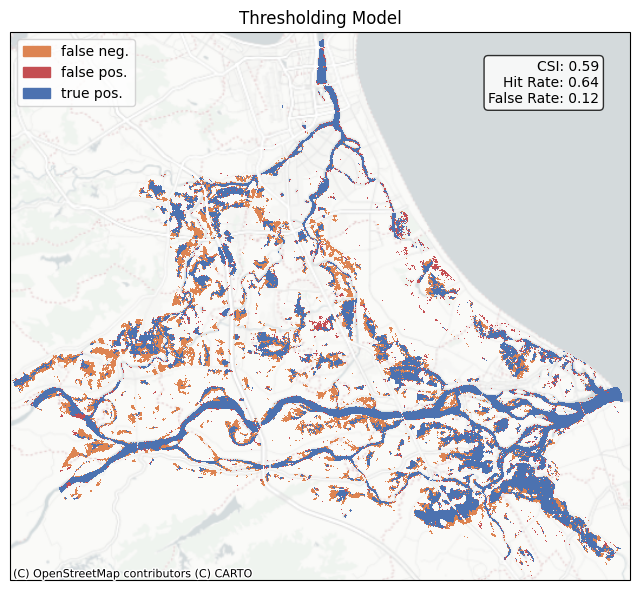

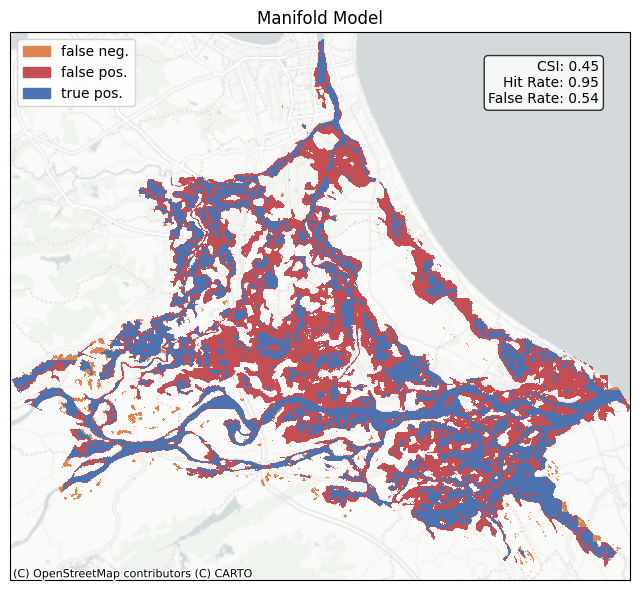

In [16]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import contextily as ctx
import numpy as np
# Confusion map colors
cm_dict = {
    1: ('false neg.', '#dd8452'),
    2: ('false pos.', '#c44e52'),
    3: ('true pos.', '#4c72b0'),
}
levels = [k for k in cm_dict.keys()] + [4]
colors = [v[1] for v in cm_dict.values()]
ticklabs = [v[0] for v in cm_dict.values()]
cmap, norm = mpl.colors.from_levels_and_colors(levels, colors)

# Map extent (lon_min, lon_max, lat_min, lat_max)
extent = [da_tm_cm.lon.min(), da_tm_cm.lon.max(), da_tm_cm.lat.min(), da_tm_cm.lat.max()]

def plot_single_cm(da_cm, ds_skill, cmap, norm, extent, fig_title="Validation"):
    fig = plt.figure(figsize=(8, 6))
    ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    
    # Title with time and water level
    time_str = str(ds_skill.time.values)[:10]
    water_level = ds_skill.water_level.item()
    
    # Optional basemap
    try:
        ctx.add_basemap(ax, crs=ccrs.PlateCarree(), source=ctx.providers.CartoDB.PositronNoLabels)
    except:
        pass
    
    # Plot confusion map (only positive codes)
    da_cm.where(da_cm>0).plot(
        ax=ax, cmap=cmap, norm=norm, add_colorbar=False, transform=ccrs.PlateCarree()
    )
    ax.set_title(f"{fig_title}", fontsize=12)
    # Legend
    handles = [mpl.patches.Patch(color=colors[i], label=ticklabs[i]) for i in range(len(colors))]
    ax.legend(handles=handles, loc='upper left')
    
    # Metrics box inside the figure (top-right corner)
    hr, csi, fr = np.round(ds_skill['H'].item(),2), np.round(ds_skill['C'].item(),2), np.round(ds_skill['F'].item(),2)
    metrics_text = f"CSI: {csi}\nHit Rate: {hr}\nFalse Rate: {fr}"
    ax.text(0.95, 0.95, metrics_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# Example usage: plot Thresholding model
plot_single_cm(da_tm_cm, ds_tm_skill, cmap, norm, extent, fig_title="Thresholding Model")

# Example usage: plot Manifold model
plot_single_cm(da_mm_cm, ds_mm_skill, cmap, norm, extent, fig_title="Manifold Model")
